In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{3}"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torchvision import transforms
import joblib
from torchsummary import summary
import pytorch_ssim
import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initial settings

In [48]:
lr=0.001
batch_size=32

ntimesteps = 499

t0 = time.time()

print(t0)

root_path = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/'

1708100449.416238


## Load data

In [49]:
datasetFolder = 'Flow_Data'
xysize = 256

samples = []
for i in range(ntimesteps):
    s = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/' + datasetFolder + '/InterpolatedResult256/InterpolatedResult256Raw/FpB_Interpolated_t{}_Velocity_{}_{}.npy'.format(
        i, xysize, xysize))
    samples.append(s)
    print(s.shape)

(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 256, 256)
(2, 25

In [50]:
concatenated_data = np.stack(samples, axis=0)
print(concatenated_data.shape)

(499, 2, 256, 256)


## Create data loader

In [51]:
dataloader = DataLoader(concatenated_data, batch_size=batch_size, shuffle=True)

## Define the model

### 1. latent_channel_number = 8

In [7]:
fist_hidden_layer = 16
second_hidden_layer = 32
latent_channel_number = 8


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(2, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(fist_hidden_layer, latent_channel_number, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channel_number, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(fist_hidden_layer, 2, kernel_size=2, stride=2, padding=0),   
            nn.Identity()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (2,256, 256))
summary(autoencoder, (2,384, 384))
summary(autoencoder, (2,384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             144
         LeakyReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           2,080
         LeakyReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 16, 65, 65]           2,064
         LeakyReLU-6           [-1, 16, 65, 65]               0
            Conv2d-7            [-1, 8, 64, 64]             520
         LeakyReLU-8            [-1, 8, 64, 64]               0
   ConvTranspose2d-9           [-1, 16, 65, 65]             528
        LeakyReLU-10           [-1, 16, 65, 65]               0
  ConvTranspose2d-11           [-1, 32, 64, 64]           2,080
        LeakyReLU-12           [-1, 32, 64, 64]               0
  ConvTranspose2d-13         [-1, 16, 128, 128]           2,064
        LeakyReLU-14         [-1, 16, 1

### 2. latent_channel_number = 4

In [30]:
fist_hidden_layer = 16
second_hidden_layer = 32
latent_channel_number = 4


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(2, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(fist_hidden_layer, latent_channel_number, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channel_number, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(fist_hidden_layer, 2, kernel_size=2, stride=2, padding=0),   
            nn.Identity()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [31]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (2,256, 256))
summary(autoencoder, (2,384, 384))
summary(autoencoder, (2,384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             144
         LeakyReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           2,080
         LeakyReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 16, 65, 65]           2,064
         LeakyReLU-6           [-1, 16, 65, 65]               0
            Conv2d-7            [-1, 4, 64, 64]             260
         LeakyReLU-8            [-1, 4, 64, 64]               0
   ConvTranspose2d-9           [-1, 16, 65, 65]             272
        LeakyReLU-10           [-1, 16, 65, 65]               0
  ConvTranspose2d-11           [-1, 32, 64, 64]           2,080
        LeakyReLU-12           [-1, 32, 64, 64]               0
  ConvTranspose2d-13         [-1, 16, 128, 128]           2,064
        LeakyReLU-14         [-1, 16, 1

### 3. latent_channel_number = 2

In [27]:
first_hidden_layer = 16
second_hidden_layer = 32
third_hidden_layer = 2
latent_channel_number = 2


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(2, first_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(first_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=1),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(second_hidden_layer, first_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(first_hidden_layer, third_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(third_hidden_layer, latent_channel_number, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channel_number, third_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(third_hidden_layer, first_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(first_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(second_hidden_layer, first_hidden_layer, kernel_size=2, stride=2, padding=1),  
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(first_hidden_layer, 2, kernel_size=2, stride=2, padding=0),   
            nn.Identity()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [28]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (2,256, 256))
summary(autoencoder, (2,384, 384))
summary(autoencoder, (2,384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             144
         LeakyReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 65, 65]           2,080
         LeakyReLU-4           [-1, 32, 65, 65]               0
            Conv2d-5           [-1, 16, 66, 66]           2,064
         LeakyReLU-6           [-1, 16, 66, 66]               0
            Conv2d-7            [-1, 2, 65, 65]             130
         LeakyReLU-8            [-1, 2, 65, 65]               0
            Conv2d-9            [-1, 2, 64, 64]              18
        LeakyReLU-10            [-1, 2, 64, 64]               0
  ConvTranspose2d-11            [-1, 2, 65, 65]              18
        LeakyReLU-12            [-1, 2, 65, 65]               0
  ConvTranspose2d-13           [-1, 16, 66, 66]             144
        LeakyReLU-14           [-1, 16,

## Train the model

In [32]:
# Specify the IDs of the GPUs you want to use
# os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"

# Initialize a new run
wandb.init(project="compression - 2 latent channels")

# If there are multiple GPUs, wrap the model with nn.DataParallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    autoencoder = nn.DataParallel(autoencoder)

# Instantiate the model, loss function, and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss works well for image reconstruction
# criterion = pytorch_ssim.SSIM(window_size = 11)  # Use SSIM loss
# def ssim_multichannel(img1, img2, window_size=11):
#     # Assume img1 and img2 are 4D tensors [batch_size, channels, height, width]
#     ssim_sum = 0
#     for i in range(img1.shape[1]):
#         ssim_sum += pytorch_ssim.ssim(img1[:, i, :, :].unsqueeze(1), img2[:, i, :, :].unsqueeze(1), window_size=window_size)
#         print(i)
#     return ssim_sum / img1.shape[1]  # Average over channels

optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

num_epochs = 1200

# Optionally, you can add the following line to watch your model in wandb interface
wandb.watch(autoencoder)

# Training loop
for epoch in range(num_epochs):
    for data in dataloader:
        inputs = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        # loss = 1 - ssim_multichannel(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Log the loss to wandb
    wandb.log({"loss": loss.item()})

print("Training time:", time.time()-t0)

# Save the model weights to wandb
torch.save(autoencoder.state_dict(), "autoencoder.pth")
wandb.save("autoencoder.pth")

# Log the model's architecture
wandb.config.model_architecture = str(autoencoder)

# Create a new artifact
artifact = wandb.Artifact('model', type='model')

# Add the file to the artifact
artifact.add_file('autoencoder.pth')

# Save the artifact to Weights & Biases
wandb.log_artifact(artifact)

loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.07455


2024-02-16 15:59:32.130051: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Epoch [1/1200], Loss: 1.8087
Epoch [2/1200], Loss: 1.2692
Epoch [3/1200], Loss: 0.8405
Epoch [4/1200], Loss: 0.6697
Epoch [5/1200], Loss: 0.6664
Epoch [6/1200], Loss: 0.5863
Epoch [7/1200], Loss: 0.6198
Epoch [8/1200], Loss: 0.5349
Epoch [9/1200], Loss: 0.5005
Epoch [10/1200], Loss: 0.3739
Epoch [11/1200], Loss: 0.4192
Epoch [12/1200], Loss: 0.3925
Epoch [13/1200], Loss: 0.3236
Epoch [14/1200], Loss: 0.3452
Epoch [15/1200], Loss: 0.2541
Epoch [16/1200], Loss: 0.2246
Epoch [17/1200], Loss: 0.1834
Epoch [18/1200], Loss: 0.1695
Epoch [19/1200], Loss: 0.1675
Epoch [20/1200], Loss: 0.1535
Epoch [21/1200], Loss: 0.1630
Epoch [22/1200], Loss: 0.1513
Epoch [23/1200], Loss: 0.1445
Epoch [24/1200], Loss: 0.1451
Epoch [25/1200], Loss: 0.1408
Epoch [26/1200], Loss: 0.1245
Epoch [27/1200], Loss: 0.1209
Epoch [28/1200], Loss: 0.1274
Epoch [29/1200], Loss: 0.1237
Epoch [30/1200], Loss: 0.1123
Epoch [31/1200], Loss: 0.0985
Epoch [32/1200], Loss: 0.1004
Epoch [33/1200], Loss: 0.1010
Epoch [34/1200], Lo

## Load saved model

In [34]:
run = wandb.init()
artifact = run.use_artifact('guodh/compression - 2 latent channels/model:v2', type='model')
artifact_dir = artifact.download()

# Load the model
autoencoder = Autoencoder()

# Load the model state dictionary from the downloaded artifact
autoencoder.load_state_dict(torch.load(os.path.join(artifact_dir, "autoencoder.pth")))

loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.02625


2024-02-16 16:09:24.775147: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


<All keys matched successfully>

## Generate result plots

### 6*6 domain

(2, 256, 256) 131072
latent space shape torch.Size([1, 4, 64, 64]) 16384
(1, 2, 256, 256)


<Figure size 432x288 with 0 Axes>

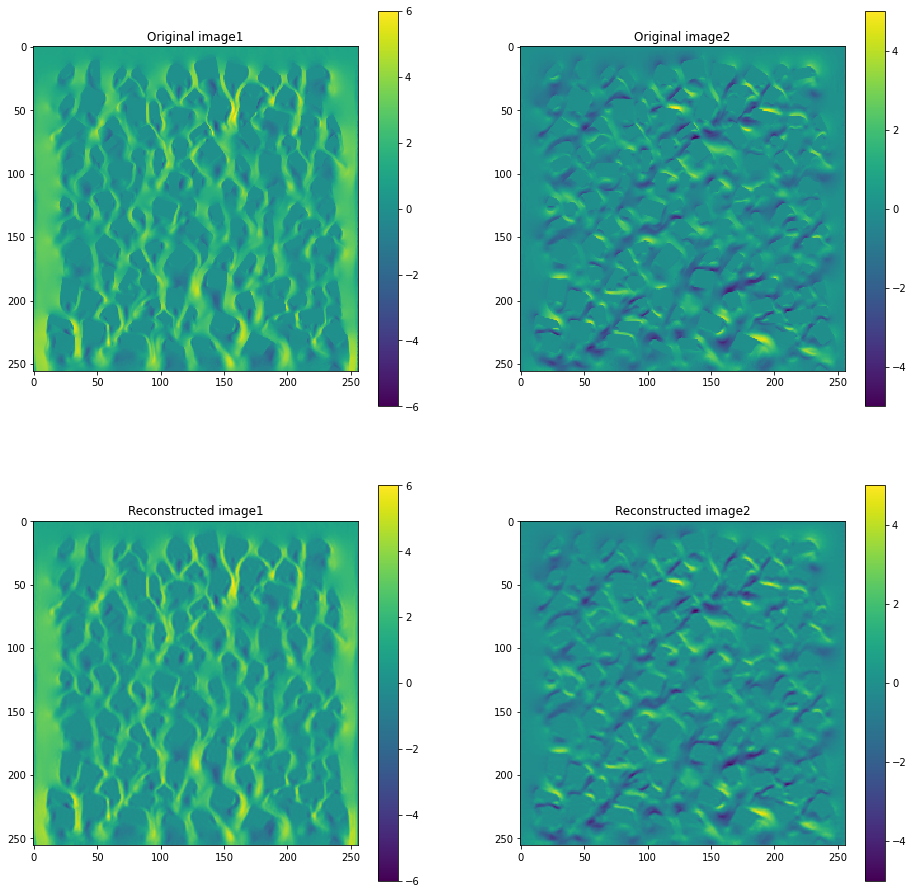

In [52]:
autoencoder.cpu().eval()

# Testing set
dataP = concatenated_data[70]
print(dataP.shape, dataP.shape[-1]*dataP.shape[-2]*dataP.shape[-3])

vmax_u = 6
vmin_u = -6
vmax_v = 5
vmin_v = -5

size_start = 0
size_end = 256

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(16, 16))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none', vmin=vmin_u, vmax=vmax_u)
axarr[0][0].title.set_text('Original image1')
f.colorbar(sub1, ax=axarr[0][0])

sub2 = axarr[0][1].imshow(np.rot90(dataP[1, size_start:size_end,size_start:size_end], 4), interpolation='none', vmin=vmin_v, vmax=vmax_v)
axarr[0][1].title.set_text('Original image2')
f.colorbar(sub2, ax=axarr[0][1])

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 4).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 2, 256, 256))
print('latent space shape', latent_space_output.shape, latent_space_output.shape[-1]*latent_space_output.shape[-2]*latent_space_output.shape[-3])
res = autoencoder(input_data.view(1, 2, 256, 256))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none', vmin=vmin_u, vmax=vmax_u)
axarr[1][0].title.set_text('Reconstructed image1')
f.colorbar(sub3, ax=axarr[1][0])

sub4 = axarr[1][1].imshow(output_data[0,1, :,:], interpolation='none', vmin=vmin_v, vmax=vmax_v)
axarr[1][1].title.set_text('Reconstructed image2')
f.colorbar(sub4, ax=axarr[1][1])

plt.show()

### 9*9 domain

In [53]:
datasetFolder = 'Flow_Data_9_9'
xysize = 384
ntimesteps = 399

samples_384 = []
for i in range(ntimesteps):
    s = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/' + datasetFolder + '/FpB_Interpolated_Velocity_384_384/FpB_Interpolated_t{}_Velocity_{}_{}.npy'.format(i, xysize, xysize))
    samples_384.append(s)
    # print(s.shape)

concatenated_data_384 = np.stack(samples_384, axis=0)
print(concatenated_data_384.shape)

(399, 2, 384, 384)


(2, 384, 384) 294912
latent space shape torch.Size([1, 4, 96, 96]) 36864
(1, 2, 384, 384)


<Figure size 432x288 with 0 Axes>

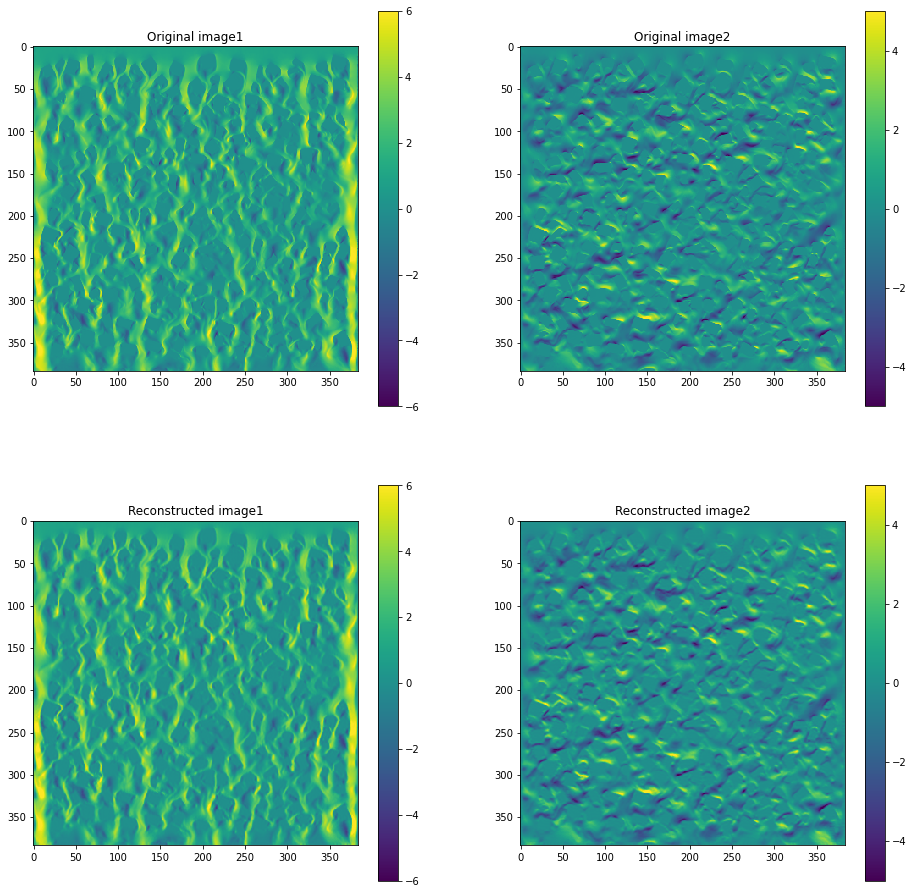

In [56]:
autoencoder.cpu().eval()

# Testing set
dataP = concatenated_data_384[200]
print(dataP.shape, dataP.shape[-1]*dataP.shape[-2]*dataP.shape[-3])

vmax_u = 6
vmin_u = -6
vmax_v = 5
vmin_v = -5

size_start = 0
size_end = 384

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(16, 16))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none', vmin=vmin_u, vmax=vmax_u)
axarr[0][0].title.set_text('Original image1')
f.colorbar(sub1, ax=axarr[0][0])

sub2 = axarr[0][1].imshow(np.rot90(dataP[1, size_start:size_end,size_start:size_end], 4), interpolation='none', vmin=vmin_v, vmax=vmax_v)
axarr[0][1].title.set_text('Original image2')
f.colorbar(sub2, ax=axarr[0][1])

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 4).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 2, xysize, xysize))
print('latent space shape', latent_space_output.shape, latent_space_output.shape[-1]*latent_space_output.shape[-2]*latent_space_output.shape[-3])
res = autoencoder(input_data.view(1, 2, xysize, xysize))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none', vmin=vmin_u, vmax=vmax_u)
axarr[1][0].title.set_text('Reconstructed image1')
f.colorbar(sub3, ax=axarr[1][0])

sub4 = axarr[1][1].imshow(output_data[0,1, :,:], interpolation='none', vmin=vmin_v, vmax=vmax_v)
axarr[1][1].title.set_text('Reconstructed image2')
f.colorbar(sub4, ax=axarr[1][1])

plt.show()